### Typical Imports, plus some useful functions 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import aperCor

import imp
imp.reload(aperCor)

<module 'aperCor' from '/Users/zjennings/astro/sluggs_phot_calibration/aperCor.py'>

### Run our photometry, using the .sex config file that you've already defined for this observation.

In [2]:
#location of the imaging file directory. modify this for your own purposes
directory = ''

#name of the image file
file = directory+'n4486_r.fits'

#name of the config file
config_file = 'n4486_r_aper.seconfig'

#sepcify the apertures used. I recommend about a dozen total apertures, 
apers = np.array([4,5,6,8,10,15,25,30,40,50,60,70,80,90])

###### Sample configuration file. Save this using the config_file name you define above, in the appropriate directory.
Make sure to update catalog_name, parameter file name, and the aperture list as we defined them above. Other values may need to be tweaked on a case-by-case basis, but no easy defined methodology for that yet.

###### Sample parameter file. Save this using the parameter file name you defined in the .seconfig file above, same directory as specified above.
Make sure that order follows the pattern below, including the same number of apertures as you choose to specify in the above file.

In [3]:
#after everything specified and all config files are saved, can run sextractor using this command
run = os.system("sex -c "+ config_file + ' ' + file)

In [4]:
#read in the data. take this catalog name from what you specified for the above file.
data = np.loadtxt('r_n4486_aper.cat')

### Make the magnitude vs. aperture difference plot to select reasonable locus of stars to choose from.
Iterate on fwhm_max, fwhm_min, saturation and faint cuts to select reasonable sample.

meas_aper corresponds to the index of the aperture array to select the photometry value that we will use to measure.

cor_aper corresponds to the index of the aperture array to correct stars to. 

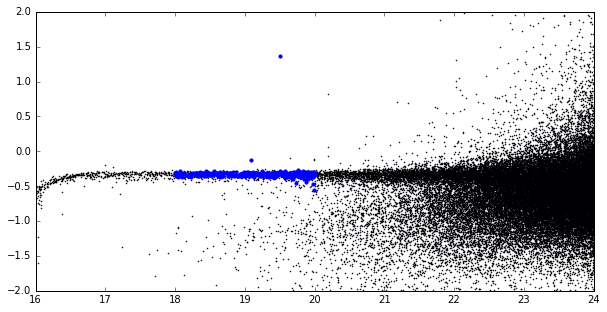

In [25]:
#iterate on these values to select a reasonable stellar locus. Initially set wide values and then
#narrow down to select reasonable locus.
fwhm_max = 4.7   #maximum FWHM measurement to select

fwhm_min = 4.0  #minimum FWHM to select out a reasonable locus of stars

sat_cut = 18     #bright limiting magnitude. 
#Stars above this may be saturated, usually set to left end of main stellar locus

faint_cut = 20  #faint limiting magnitude. Select at point where locus seems to expand, stars below this
#too noisy to get good constraint from

init_meas_aper = 3 #initial aperture for making the difference plot. Anything around 5-10 pix is fine, will refine
#later

init_cor_aper = 8 #initial correction aperture for making difference plot. Anything around ~30 pix is fine,
#will also refine later.

aper_cor,good = aperCor.calc_aper_cor(data,meas_aper=init_meas_aper,cor_aper=init_cor_aper,\
                                      fwhm_max=fwhm_max,fwhm_min=fwhm_min,\
                                      sat_cut=sat_cut,faint_cut=faint_cut)
aperCor.make_diff_plot(data,good,meas_aper=init_meas_aper,cor_aper=init_cor_aper,xlim=(16,24),ylim=(-2,2))

###### Make the merr plot to determine which aperture to use.
Here either 8 pix is lowest, which corresponds to the 4th aperture (index = 3).


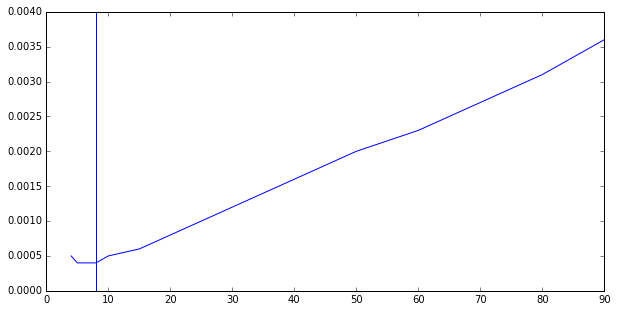

In [26]:
aperCor.make_merr_plot(data[good,:],apers)
plt.axvline(apers[3]) #just a visual guide to pick the aperture

In [27]:
#once selected, fix the final measurement aperture
fin_meas_aper = 3

### Make the COG plot to determine which aperture to correct magnitudes to. 
Just pick the lowest value that the COG seems to flatten out at. However, best not to go past 50 unless the COG looks weird, scatter increases significantly down there. Here I just picked 40 pix, which seemed reasonable to me.

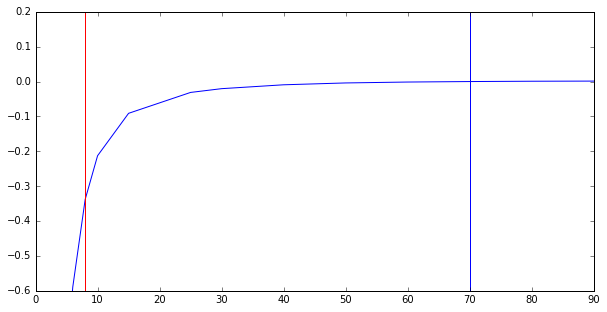

In [28]:
aperCor.make_cog_plot(data[good,:],apers,ylim=(-0.6,0.2),cor_aper=11,meas_aper=fin_meas_aper)

In [33]:
#once selected, fix the final correction aperture
fin_cor_aper = 11

### Now that the meas_aper and cor_aper have been determined, re-calculate the final aperture correction value.
Also want to double check to make sure the stellar locus still looks reasonable now that final apertures have been selected.

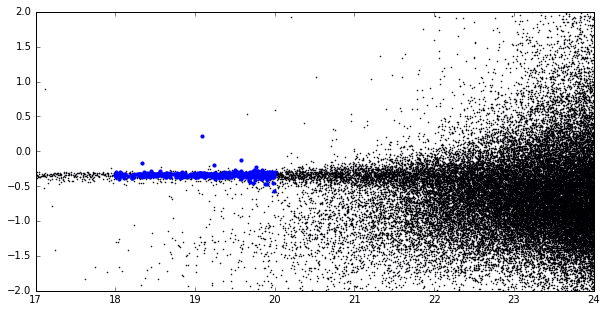

In [34]:
aper_cor,good = aperCor.calc_aper_cor(data,meas_aper=fin_meas_aper,cor_aper=fin_cor_aper,\
                                      fwhm_max=fwhm_max,fwhm_min=fwhm_min,\
                                      sat_cut=sat_cut,faint_cut=faint_cut)
aperCor.make_diff_plot(data,good,meas_aper=fin_meas_aper,cor_aper=fin_cor_aper,xlim=(17,24))

In [35]:
print(aper_cor)

0.338


### Finally, write out the photometry catalog measured from the correct aperture. 

I don't apply the aperture correction here, but do note it for future use. I actually apply it later when I'm doing zero-point corrections.

In [32]:
n_aper = apers.shape[0]
meas_aper = fin_meas_aper 
uncorrected_data = np.array([data[:,0],data[:,1],data[:,meas_aper+2],data[:,meas_aper+n_aper+2],data[:,-3],data[:,-2],data[:,-1]]).T
np.savetxt('n4486_r_uncorrected.csv',uncorrected_data,delimiter=' ',fmt='%10.10f')